In [ ]:
import torch
from transformers import AutoModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc

# Вначале для удобства лучше все тестировать на 70M модели,
# но для итоговой презентации наверное нужно будет все прогнать на 2.7 B модели
model_name = "EleutherAI/pythia-410M"

checkpoint_steps = [0] + [2**i for i in range(1, 10)] + list(range(1000, 143001, 1000))
branch_names = [f"step{step}" for step in checkpoint_steps]

In [ ]:
# Инициализируем словари для хранения норм смещений и норм весов LayerNorm
ln_weight_norms = {layer_idx: [] for layer_idx in range(24)}
ln_bias_norms = {layer_idx: [] for layer_idx in range(24)}

# Итерация по всем контрольным точкам
for branch in tqdm(branch_names[::7], desc="Processing checkpoints"):
    try:
        # Загрузка модели для текущей контрольной точки
        model = AutoModel.from_pretrained(model_name, revision=branch, trust_remote_code=True)

        # Проходимся по всем слоям
        for layer_idx, layer in enumerate(model.layers):

            # Обработка LayerNorm слоя
            ln = layer.post_attention_layernorm

            # Получаем веса и смещения LayerNorm
            ln_weight = ln.weight.detach().cpu().numpy() if ln.weight is not None else np.array([])
            ln_bias = ln.bias.detach().cpu().numpy() if ln.bias is not None else np.array([])

            # Вычисляем нормы
            ln_weight_norm = np.linalg.norm(ln_weight) if ln_weight.size > 0 else 0.0
            ln_bias_norm = np.linalg.norm(ln_bias) if ln_bias.size > 0 else 0.0

            ln_weight_norms[layer_idx].append(ln_weight_norm)
            ln_bias_norms[layer_idx].append(ln_bias_norm)

    except Exception as e:
        print(f"Error processing {branch}: {e}")
        for layer_idx in range(6):
            ln_weight_norms[layer_idx].append(np.nan)
            ln_bias_norms[layer_idx].append(np.nan)
    finally:
        # Удаляем модель и освобождаем память
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

Processing checkpoints: 100%|██████████| 22/22 [01:39<00:00,  4.54s/it]


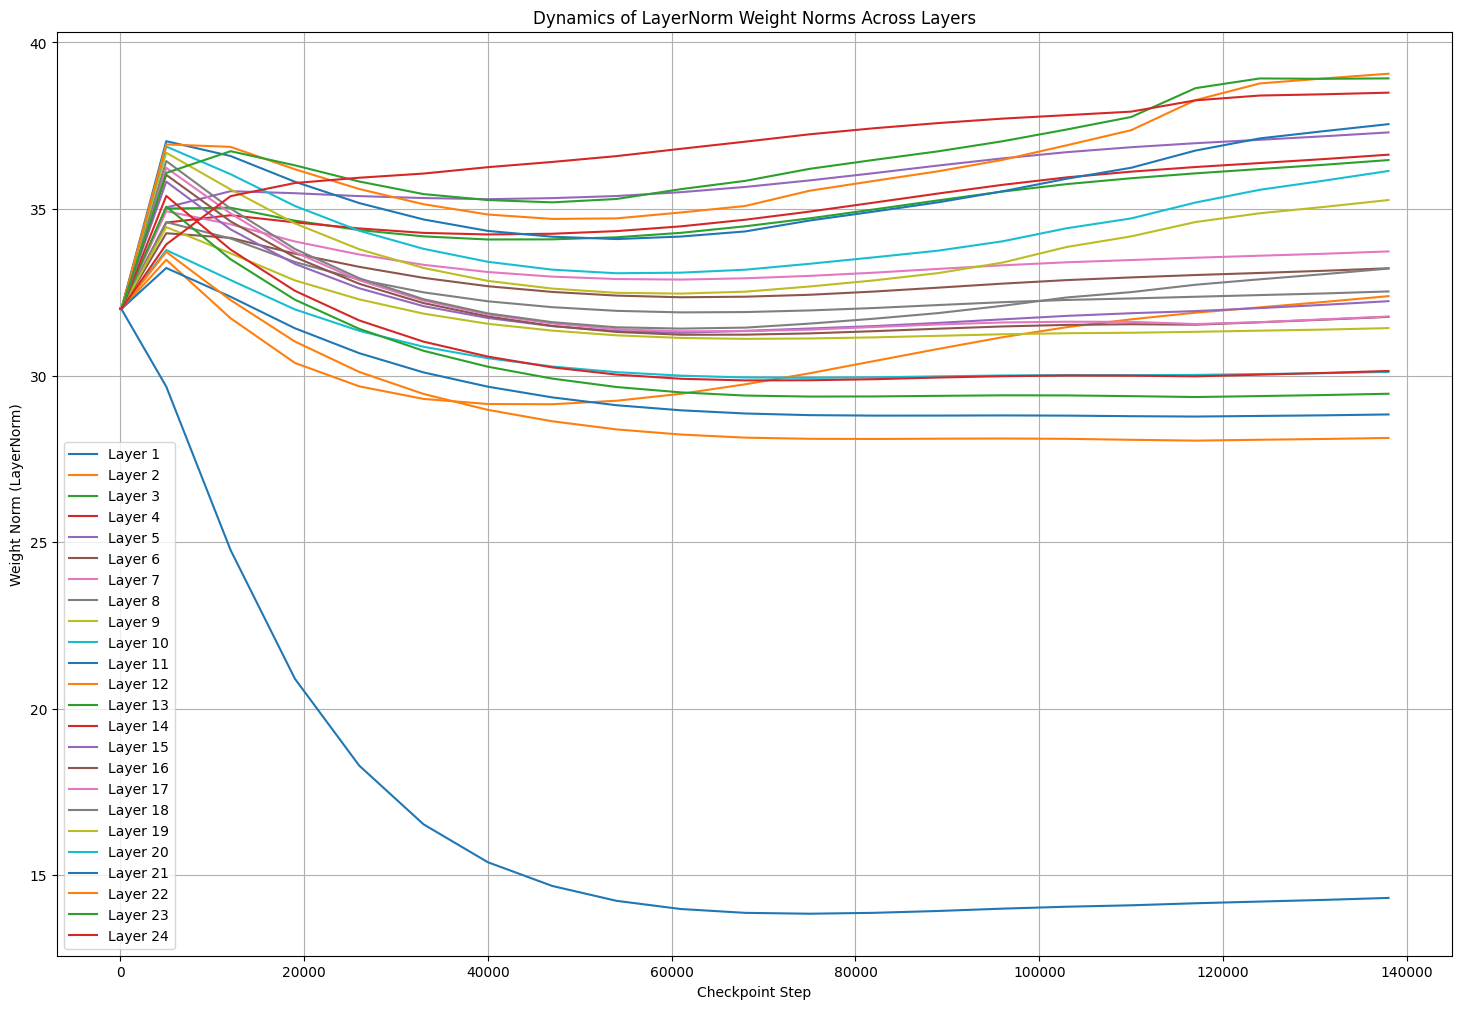

In [ ]:
# Построение графиков
plt.figure(figsize=(18, 12))

for layer_idx in range(24):
    plt.plot(checkpoint_steps[::7], ln_weight_norms[layer_idx], label=f'Layer {layer_idx + 1}')
plt.xlabel('Checkpoint Step')
plt.ylabel('Weight Norm (LayerNorm)')
plt.title('Dynamics of LayerNorm Weight Norms Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)

plt.show()

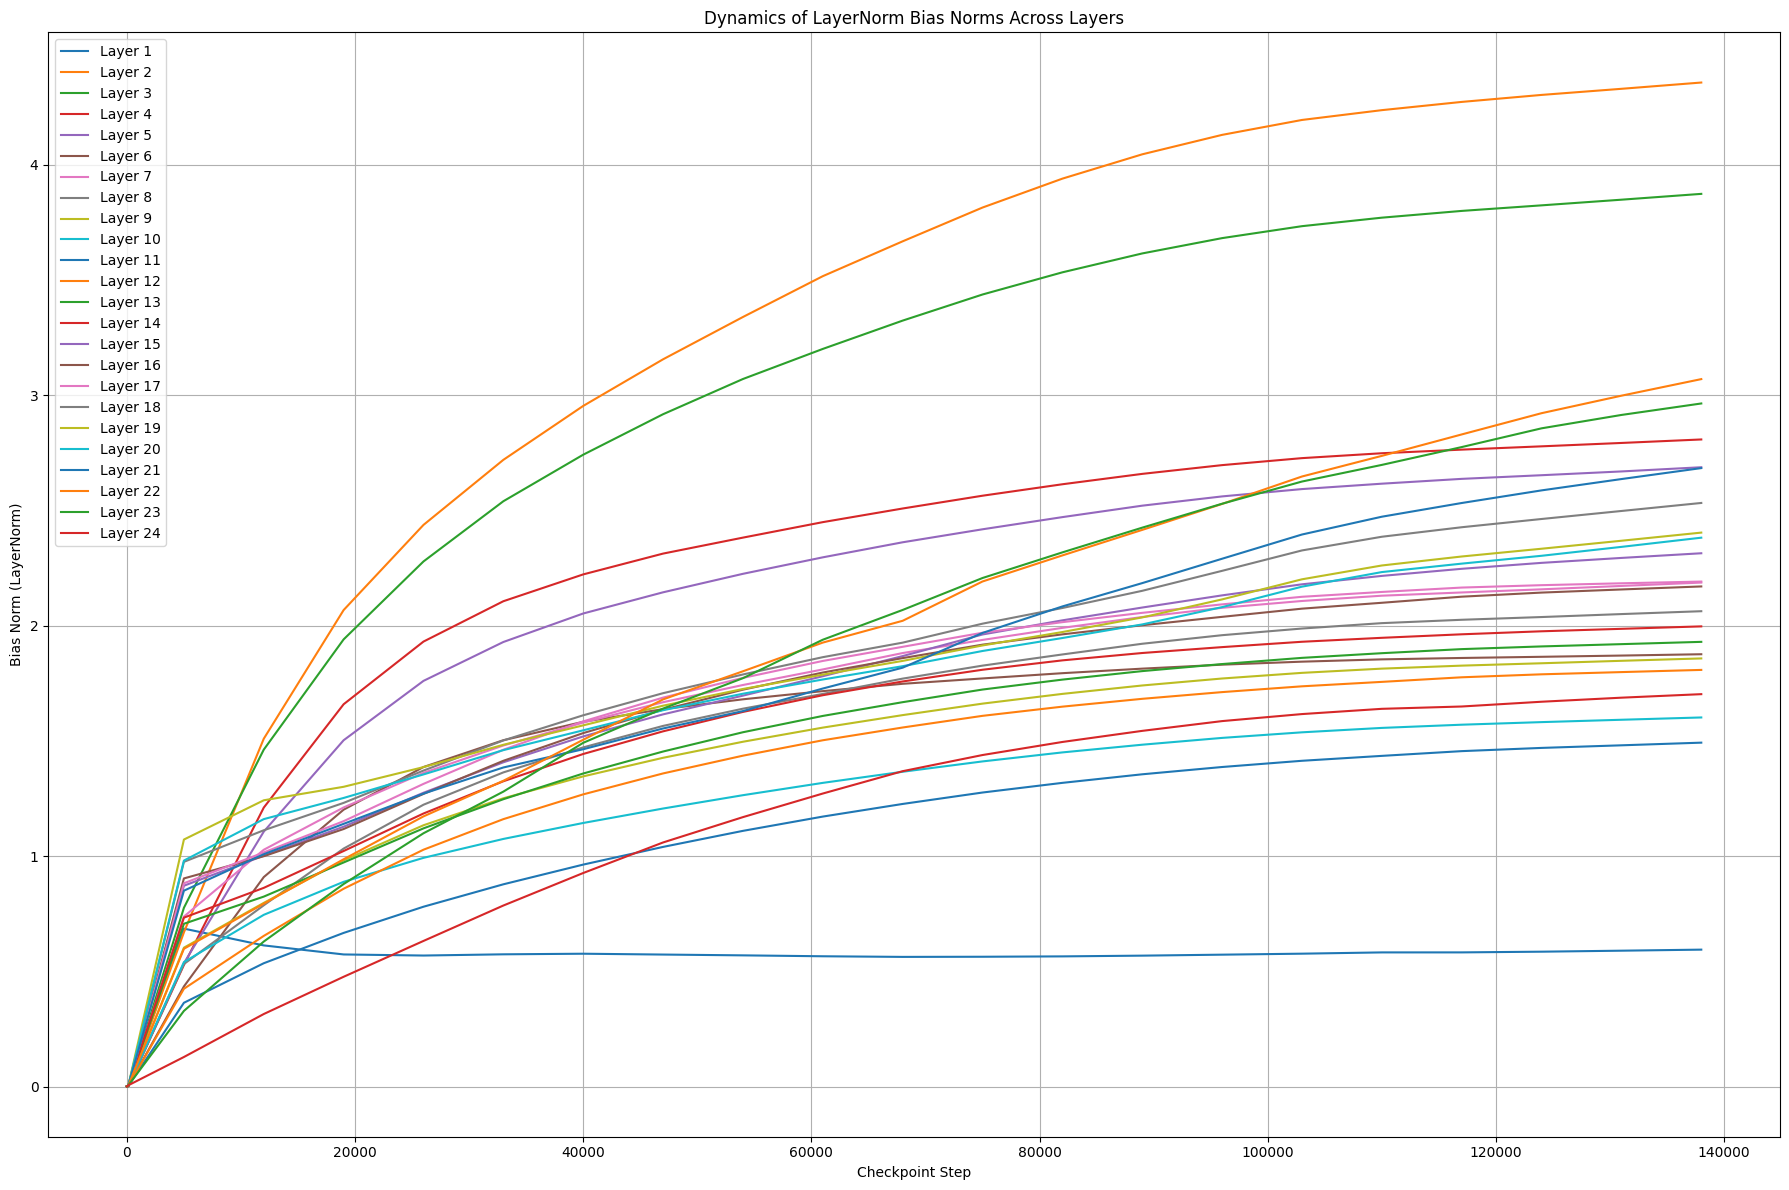

In [ ]:
# Построение графиков
plt.figure(figsize=(18, 12))
for layer_idx in range(24):
    plt.plot(checkpoint_steps[::7], ln_bias_norms[layer_idx], label=f'Layer {layer_idx + 1}')
plt.xlabel('Checkpoint Step')
plt.ylabel('Bias Norm (LayerNorm)')
plt.title('Dynamics of LayerNorm Bias Norms Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()